In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from IPython.utils import io
with io.capture_output() as captured:
  !pip install yfinance
  !pip install git+https://github.com/tensorflow/docs
  import tensorflow_docs as tfdocs
  import tensorflow_docs.modeling
  import sklearn.preprocessing
  import tensorflow as tf
  import os

In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Crypto')

from data_loader import FinanceFetch
from data_process import DataPreProcess
from models_wrap import ModelsHandler
from models_dispatcher import ModelsDispatch

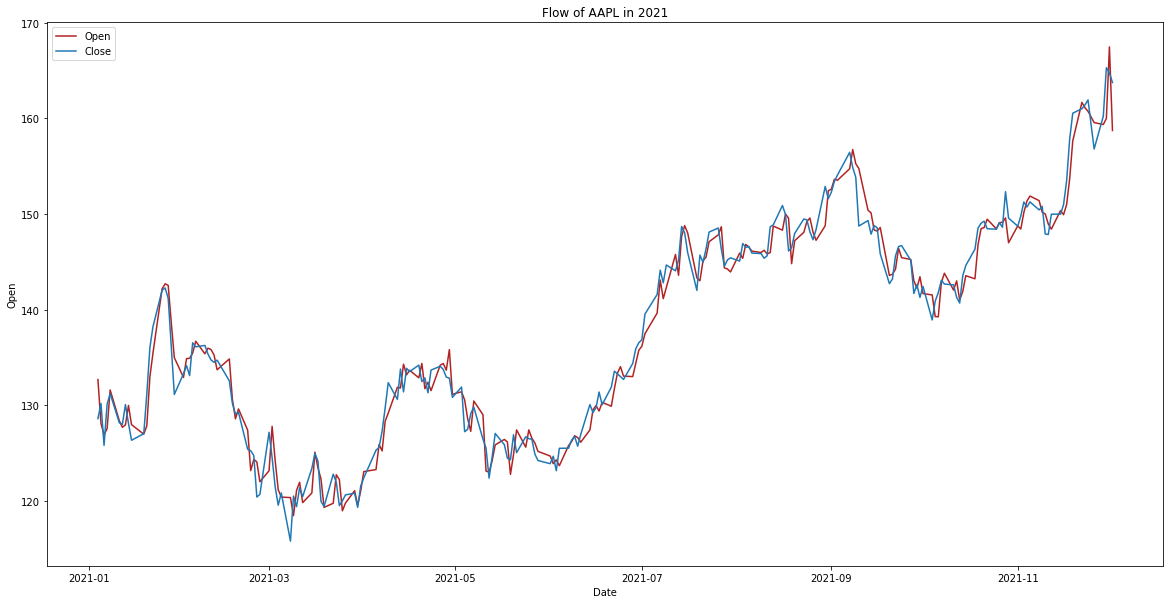

In [4]:
ticket = "AAPL"
TicketHandler = FinanceFetch(ticket)
historical_data = TicketHandler.fetch('max', plot=True, year='2021')

In [5]:
TIMESTEPS = 20

dt = DataPreProcess(scaler=sklearn.preprocessing.StandardScaler, timesteps=TIMESTEPS)
scaled_data = dt.scale(data=historical_data.loc[:, ['Open','Close','Volume']], 
                       target=historical_data.Close, 
                       timestamp=historical_data.Date)
train, test = dt.test(scaled_data, N=100)

# creating windows
X_train, y_train = dt.create_windows(train, col_x=['Open','Close','Volume'], col_y=['Close'])
X_test, y_test= dt.create_windows(test, col_x=['Open','Close','Volume'], col_y=['Close'])

Shape of transormed data: x=(10212, 20, 3), y=(10212, 1)
Shape of transormed data: x=(80, 20, 3), y=(80, 1)


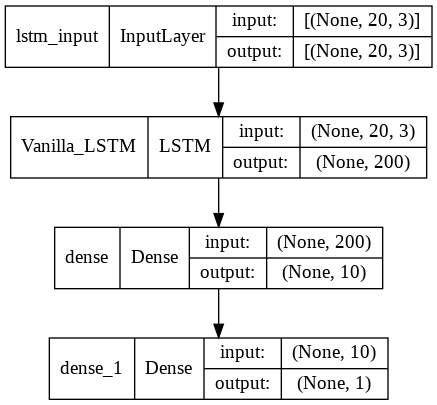

In [6]:
model_handler = ModelsDispatch(batch_size=32)
model = model_handler.light_dense_vanilla_LSTM(input_shape=(TIMESTEPS, 3), name='light dense vanilla_199-10lr_1') 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), 
              loss='mse', 
              metrics=[tf.keras.metrics.MSE, tf.keras.metrics.MAE])

model_handler.draw_model(model, ticket=ticket)

In [7]:
EPOCH = 500
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history_model = model.fit(x=X_train, 
                          y=y_train, 
                          batch_size=32, 
                          epochs=EPOCH, 
                          shuffle=True, 
                          verbose=0,
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()],
                          validation_split = 0.1)


Epoch: 0, loss:0.0099,  mean_absolute_error:0.0463,  mean_squared_error:0.0099,  val_loss:1.3241,  val_mean_absolute_error:0.7494,  val_mean_squared_error:1.3241,  
....................................................................................................
Epoch: 100, loss:0.0000,  mean_absolute_error:0.0027,  mean_squared_error:0.0000,  val_loss:0.0055,  val_mean_absolute_error:0.0475,  val_mean_squared_error:0.0055,  
.................

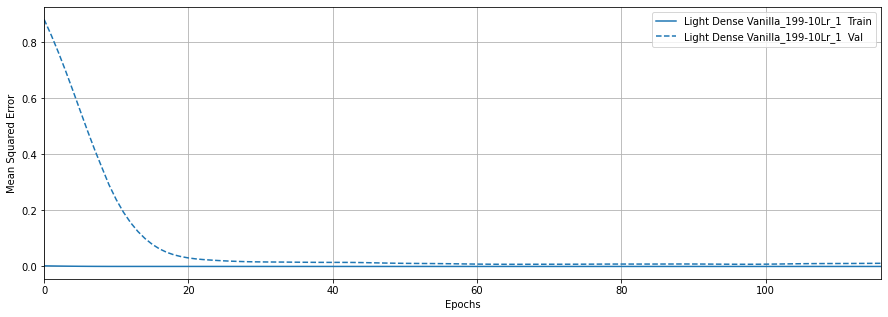

In [9]:
model_handler.plot_history_model(history_model)

In [15]:
best_model = model_handler.compare_eval(ticket).iloc[0]['model']
model = model_handler.load_model(ticket, best_model)

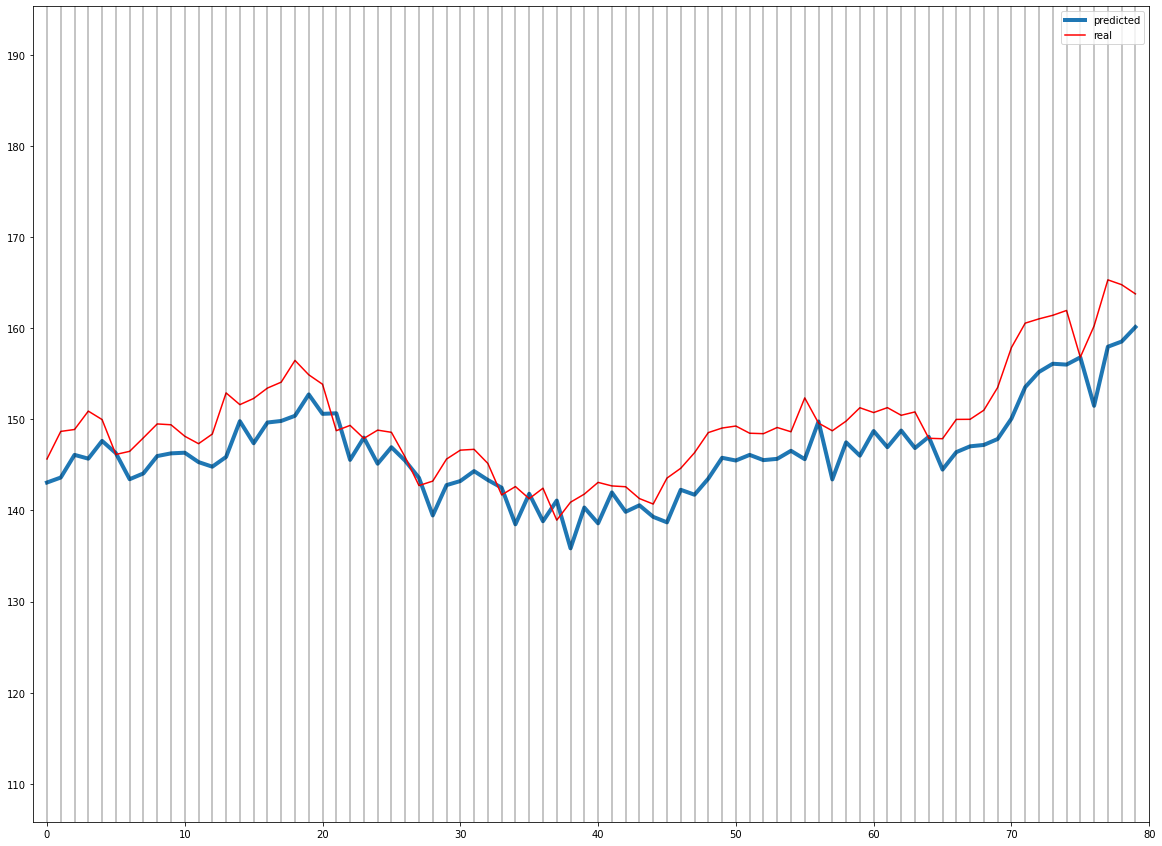

In [16]:
model_handler.plot_test_pred(model, X_test, y_test, dt.scaler_target)

In [18]:
res = model_handler.save_model_and_score(model, X_test, y_test, ticket=ticket, target_scalar=dt.scaler_target)

% Direction correct=0.6329113924050633, mse_test_mean=15.308696160605766


INFO:tensorflow:Assets written to: ./models//AAPL/light dense vanilla 200-10lr_1.json/assets


Shape of transormed data: x=(980, 20, 3), y=(980, 1)


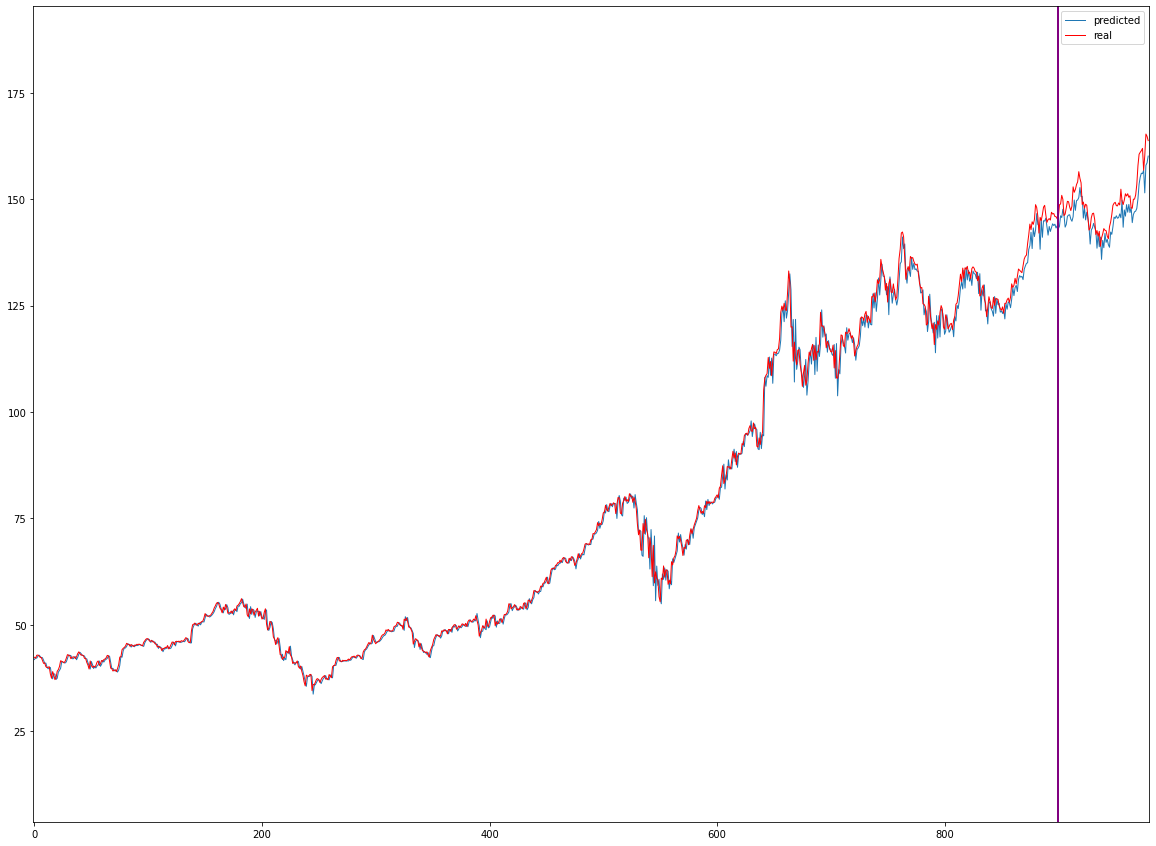

In [17]:
all_X, all_y = dt.create_windows(scaled_data.iloc[-1000:], col_x=['Open','Close','Volume'], col_y=['Close'])
model_handler.plot_test_pred(model, all_X, all_y, dt.scaler_target, H=len(X_test), lw_1=1, lw_2=1)

In [20]:
model_handler.compare_eval(ticket).sort_values('mse_mean_test')

,model,mse,mae,correct_dir,mse_mean_test,mse_std_test
7,light dense vanilla 200-10lr_1,0.0212117,0.126138,0.632911,15.308696,15.639879
18,light dense vanilla_201-10lr_1,0.0434222,0.191429,0.594937,31.374742,23.616368
13,light vanilla 205-15lr_1,0.0714554,0.250191,0.564246,51.308984,35.459333
19,light dense vanilla_199-10lr_1,0.0898177,0.286559,0.582278,64.799184,36.256184
12,light vanilla 185-7lr_1,0.103032,0.308008,0.564246,74.104104,41.757892
16,light vanilla 215-10lr_1,0.103675,0.309733,0.564246,74.537986,41.744812
3,heavy vanilla 200-100_10_1,0.116483,0.330142,0.582278,84.600379,43.307695
15,light vanilla 225-10lr_1,0.135721,0.357108,0.564246,97.623844,49.059649
2,heavy vanilla 100_10_1,0.219492,0.460594,0.582278,158.573406,60.272696
10,light vanilla 150-10lr_1,0.290634,0.529499,0.582278,208.431692,82.416254
